# PoroTomo DAS Data Processing Tutorial for SEG-Y Files

Prior to running this script, make sure the following are installed within your Python environment:
 - boto3
 - botocore
 - numpy
 - matplotlib
 - obspy
 - sys
 - os

After installation, run the following:

In [1]:
import os, sys, logging
import boto3, botocore
import numpy as np
import matplotlib.pyplot as plt

from obspy.io.segy.core import _read_segy
import obspy as obs
import obspy.signal.filter

boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))
bucket = s3.Bucket('nrel-pds-porotomo')
cwd = os.getcwd()


## Showing Info for PoroTomo AWS S3 Bucket

In [2]:
s3.meta.client.head_bucket(Bucket='nrel-pds-porotomo')

{'ResponseMetadata': {'RequestId': 'P5PAYRB8S5NDJA73',
  'HostId': 'urNIxFaBfdMjPYyYFDppjMgZXpT4jdnMLMybNTF2fyTKH/TykU22TOlB51Bk+ct4S8ze+dCPQGo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'urNIxFaBfdMjPYyYFDppjMgZXpT4jdnMLMybNTF2fyTKH/TykU22TOlB51Bk+ct4S8ze+dCPQGo=',
   'x-amz-request-id': 'P5PAYRB8S5NDJA73',
   'date': 'Tue, 03 Dec 2024 11:57:07 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'BucketRegion': 'us-west-2',
 'AccessPointAlias': False}

## Total Number of Objects in PoroTomo S3 Bucket
This code block shows the total number of objects within the bucket. For the purposes of this tutorial, we will use only two data files from 3/15, including and following a 'mystery event.'

In [3]:
count = 0
for object in bucket.objects.all():
    count+=1
    
count

KeyboardInterrupt: 

## Accessing the Data
This can be done by either pulling the data directly into the notebook from S3, or by first downloading the data to your computer and then reading it in. Both approaches are shown below.

The files used in this tutorial are specified here:

In [4]:
keys = ['DAS/SEG-Y/DASH/20160315/PoroTomo_iDAS16043_160315083149.sgy',
        'DAS/SEG-Y/DASH/20160315/PoroTomo_iDAS16043_160315083219.sgy']

file_names = ['/DAS/SEG-Y/DASH/PoroTomo_iDAS16043_160315083149.sgy',
              '/DAS/SEG-Y/DASH/PoroTomo_iDAS16043_160315083219.sgy']


### Read the Data Directly from S3
#### Reading in a Few Files

In [5]:
data_stream = []

for key in keys:
    data_stream.append(obs.read('https://nrel-pds-porotomo.s3-us-west-2.amazonaws.com/'+key,format='SEGY'))
    
data_stream

KeyboardInterrupt: 

### Downloading the Data First, and then Reading in the Data
#### Creating the directory structure for storing the DAS data

In [13]:
data_dir = cwd+'/PoroTomo_data'
print(data_dir)
try:
    os.mkdir(data_dir)
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir)

try:
    os.mkdir(data_dir+'/DAS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir)

try:
    os.mkdir(data_dir+'/DAS/SEG-Y')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
    
DASH_dir = data_dir+'/DAS/SEG-Y/DASH'
try:
    os.mkdir(DASH_dir)
except OSError:
    print ("*Creation of the directory %s failed" % DASH_dir)
else:
    print ("Successfully created the directory %s " % DASH_dir)
    
DASV_dir = data_dir+'/DAS/SEG-Y/DASV'
try:
    os.mkdir(DASV_dir)
except OSError:
    print ("*Creation of the directory %s failed" % DASV_dir)
else:
    print ("Successfully created the directory %s " % DASV_dir)
    
print('Downloaded data will be stored here:',data_dir)

/Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data
Successfully created the directory /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data 
/Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data
Successfully created the directory /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data 
/Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data
Successfully created the directory /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data 
Successfully created the directory /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data/DAS/SEG-Y/DASH 
Successfully created the directory /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data/DAS/SEG-Y/DASV 
Downloaded data will be stored here: /Users/ntaverna/Documents/GDR/porotomo/PoroTomo_data


#### Downloading Files

##### Download a Subset of the PoroTomo DAS Files

The following code block allows the user to download multiple files from AWS. To download all files, use the commented out code in the block below

In [6]:
for index in np.arange(len(keys)):
    key=keys[index]; file_name=file_names[index]
    file_path = data_dir+file_name
    bucket.download_file(key,file_path)
    print(key,'successfully downloaded')


NameError: name 'data_dir' is not defined

#### Download all PoroTomo DAS Files 
##### WARNING: This may take several days to run and will download ~40 TB of data


In [ ]:
## minimum key length set to 15 to avoid including directories as objects
# min_key_length = 15 

# for object in bucket.objects.all():
#     key = object.key
#     if len(key) < min_key_length:
#         continue
#     file_path = data_dir+'/'+key[:5]+key[14:]
#     bucket.download_file(key,file_path)
#     print(key,'successfully downloaded')

#### Reading Files for Analysis in Python
The files are read in using ObsPy's 'obspy.io.segy.core._read_segy' function, which stores individual traces in a stream with packed header info to reduce the amount of time required to import the data. The header info may be unpacked on demand (see https://docs.obspy.org/master/packages/obspy.io.segy.html for additional information). 

Since we are using data from two SEGY files, we'll store the data in an array of stream objects. This code block prints the header info for the Stream. Note that the sampling rate is 1000 Hz

In [15]:
data_stream = []
for segy in file_names:
    data_stream.append(_read_segy(data_dir+segy))
    
data_stream[0]

8721 Trace(s) in Stream:

Seq. No. in line:    1 | 2016-03-15T08:31:49.000000Z - 2016-03-15T08:32:18.999000Z | 1000.0 Hz, 30000 samples
...
(8719 other traces)
...
Seq. No. in line: 8721 | 2016-03-15T08:31:49.000000Z - 2016-03-15T08:32:18.999000Z | 1000.0 Hz, 30000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Plotting Raw Data
### Plotting Individual Traces
Individual traces within a stream can be accessed using Stream.taces[trace_index]. In this code block, a subset of the traces are placed into an array and plotted to show change in amplitude over time at different positions along the cable.

In [4]:
sampling_rate_stream = 1000

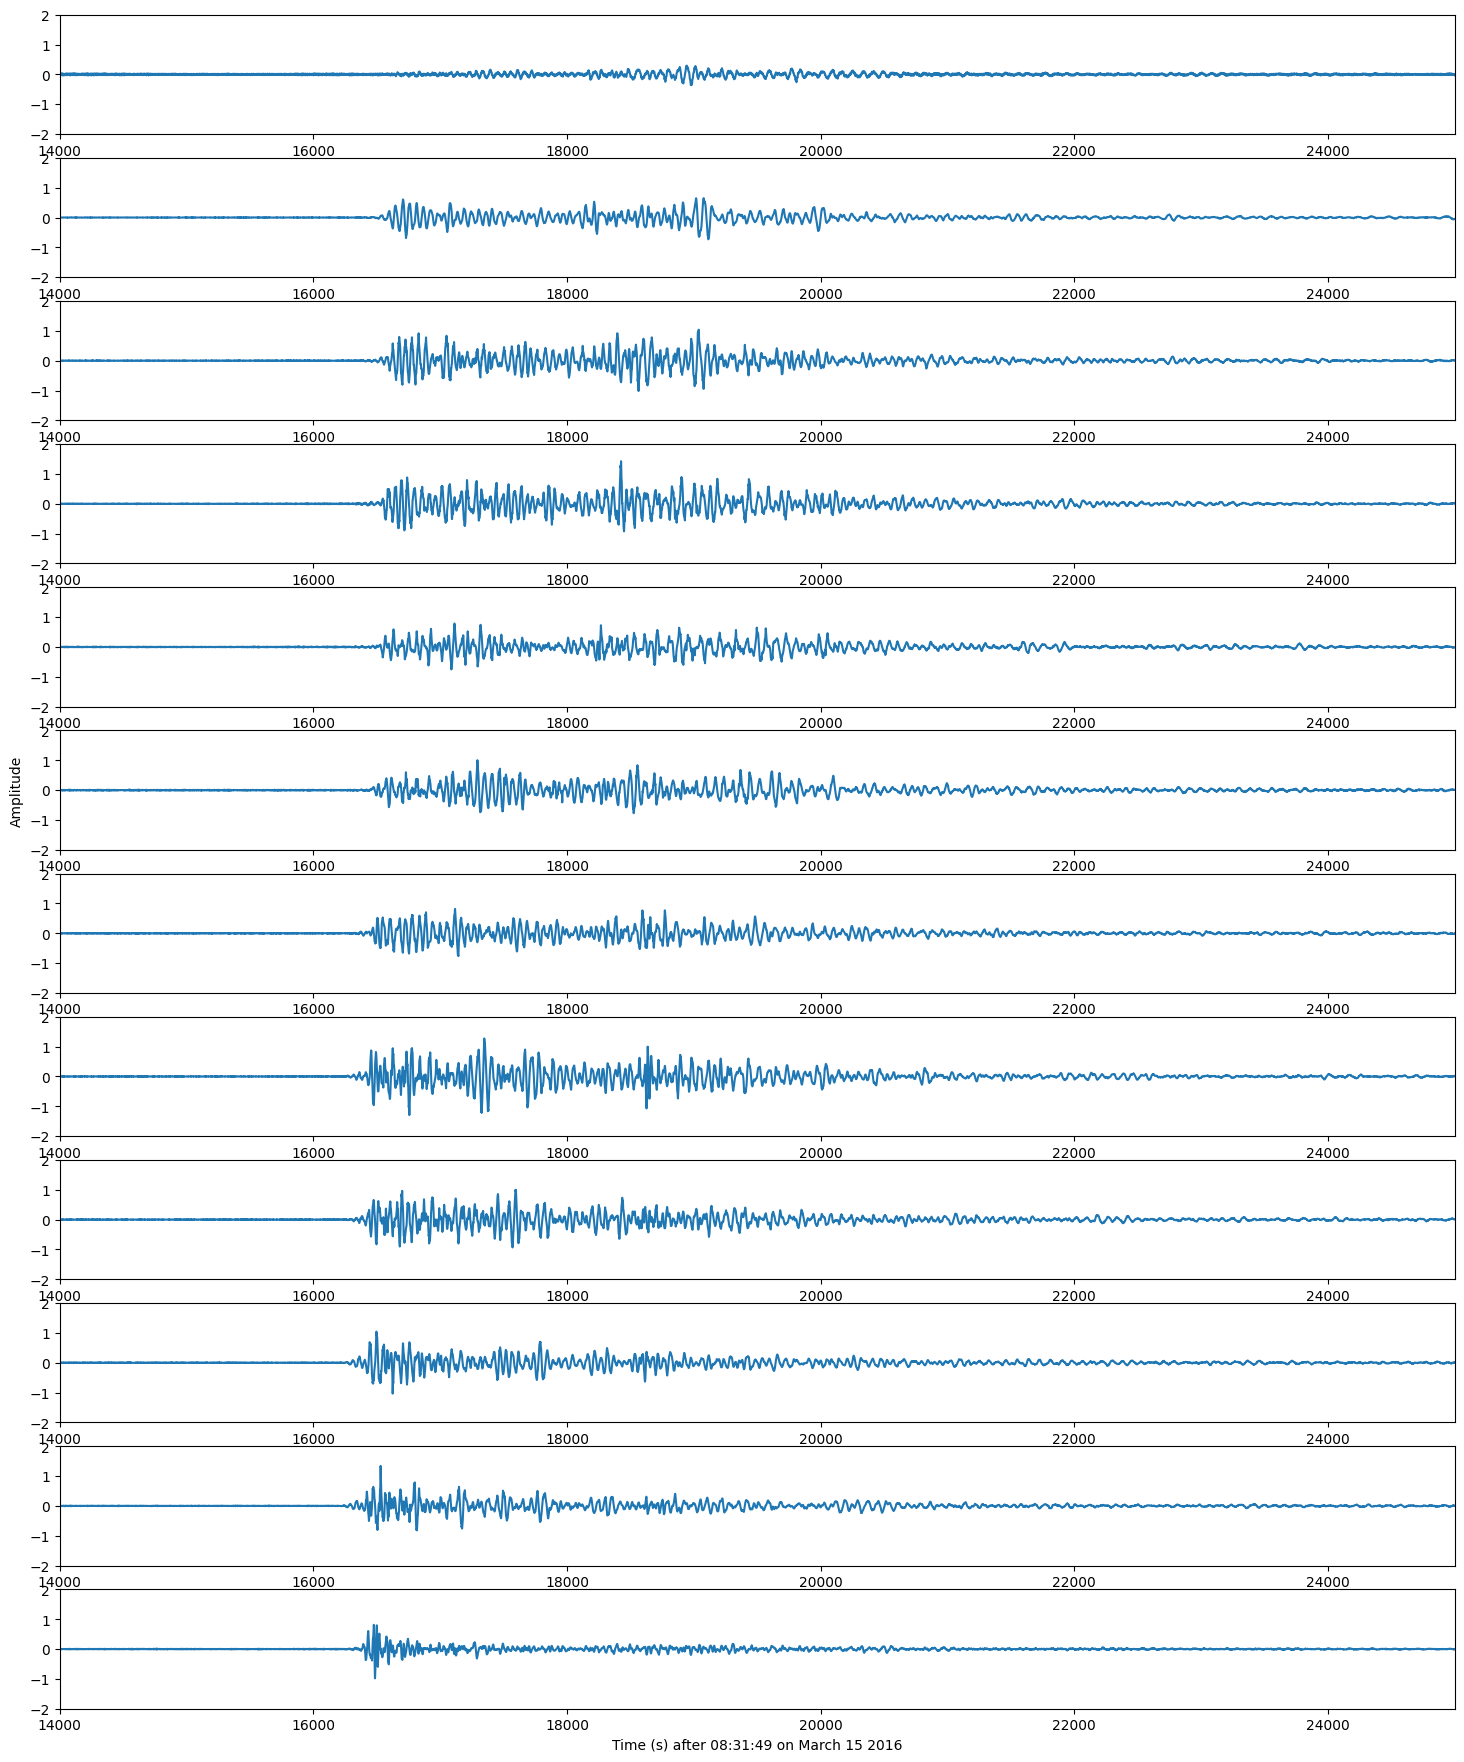

In [6]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-2,2]; xlim=[14000,25000]

for index in np.arange(num_traces):
    traces.append(data_stream[0].traces[start_trace+trace_inc*index].data)
    
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

### Plotting all Traces as an Image
#### Stacking the data for plotting as an image
For plotting using matplotlib's imshow, the trace data (Stream.traces[trace_index].data) must be stacked into a 2D numpy array.

In [8]:
raw_data = []
for index in np.arange(len(keys)):
    raw_data.append(np.stack(list(t.data for t in data_stream[index].traces)).astype('float'))


### Size of Data

In [9]:
size = sys.getsizeof(raw_data[0])+sys.getsizeof(raw_data[1])
print("size of two raw data files: {:.4f} GB".format(size*10**-9))

size of two raw data files: 4.1861 GB


### Determining Upper and Lower Limits of the Data
In order to determine upper and lower bounds for the colorbar, the 99th percentile, maximum value, and standard deviation are calculated. 

In [10]:
vm0 = np.percentile(raw_data[0], 99)
std0 = np.std(raw_data[0])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm0, raw_data[0].max(),std0))


The 99th percentile is 0.0397; the max amplitude is 2.4027; the standard deviation is  0.0292


In [11]:
vm1 = np.percentile(raw_data[1], 99)
std1 = np.std(raw_data[1])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm1, raw_data[1].max(),std1))


The 99th percentile is 0.0134; the max amplitude is 2.0574; the standard deviation is  0.0193


### Plotting all Traces as an Image Using imshow

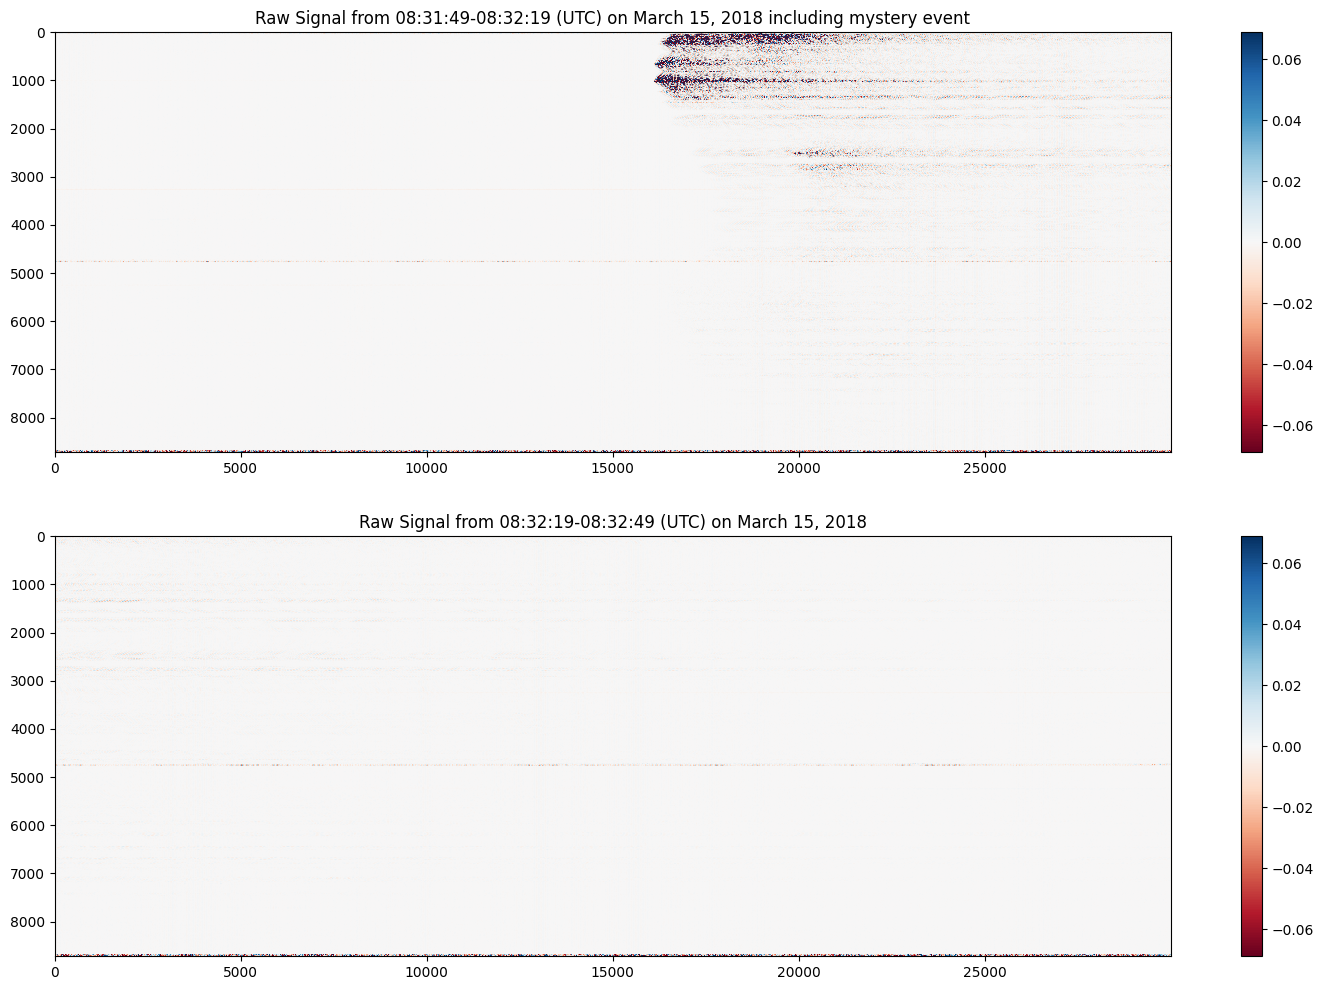

In [12]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,12))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')

noise = ax2.imshow(raw_data[1], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(noise,ax=ax2)
ax2.set_title('Raw Signal from 08:32:19-08:32:49 (UTC) on March 15, 2018')
plt.show()


### Isolating the Mystery Event

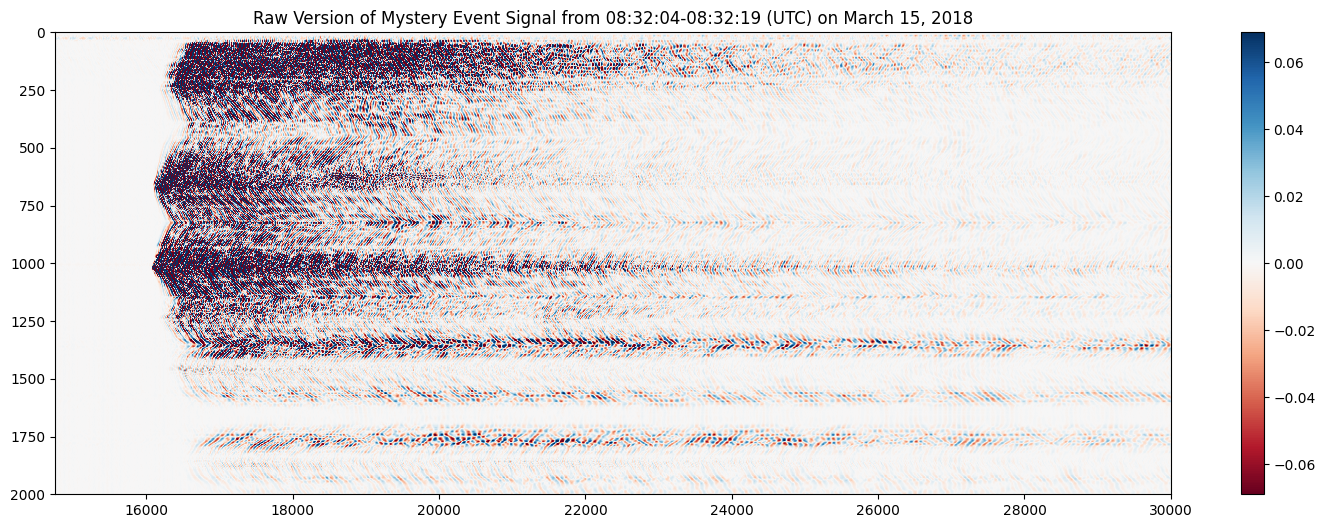

In [13]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.xlim(14750,30000)
plt.ylim(2000,0)

plt.colorbar(mystery_event)
plt.title('Raw Version of Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Filtering
ObsPy includes the following filter options:
 - bandpass
 - bandstop
 - lowpass
 - highpass
 
Here we will apply the low pass filter to only the mystery event data array.
 
### Applying Low Pass Filter

In [14]:
event_stream_filt = data_stream[0].copy()
event_stream_filt=event_stream_filt.filter('lowpass', freq=1, corners=2, zerophase=True)


### Plotting Filtered Data

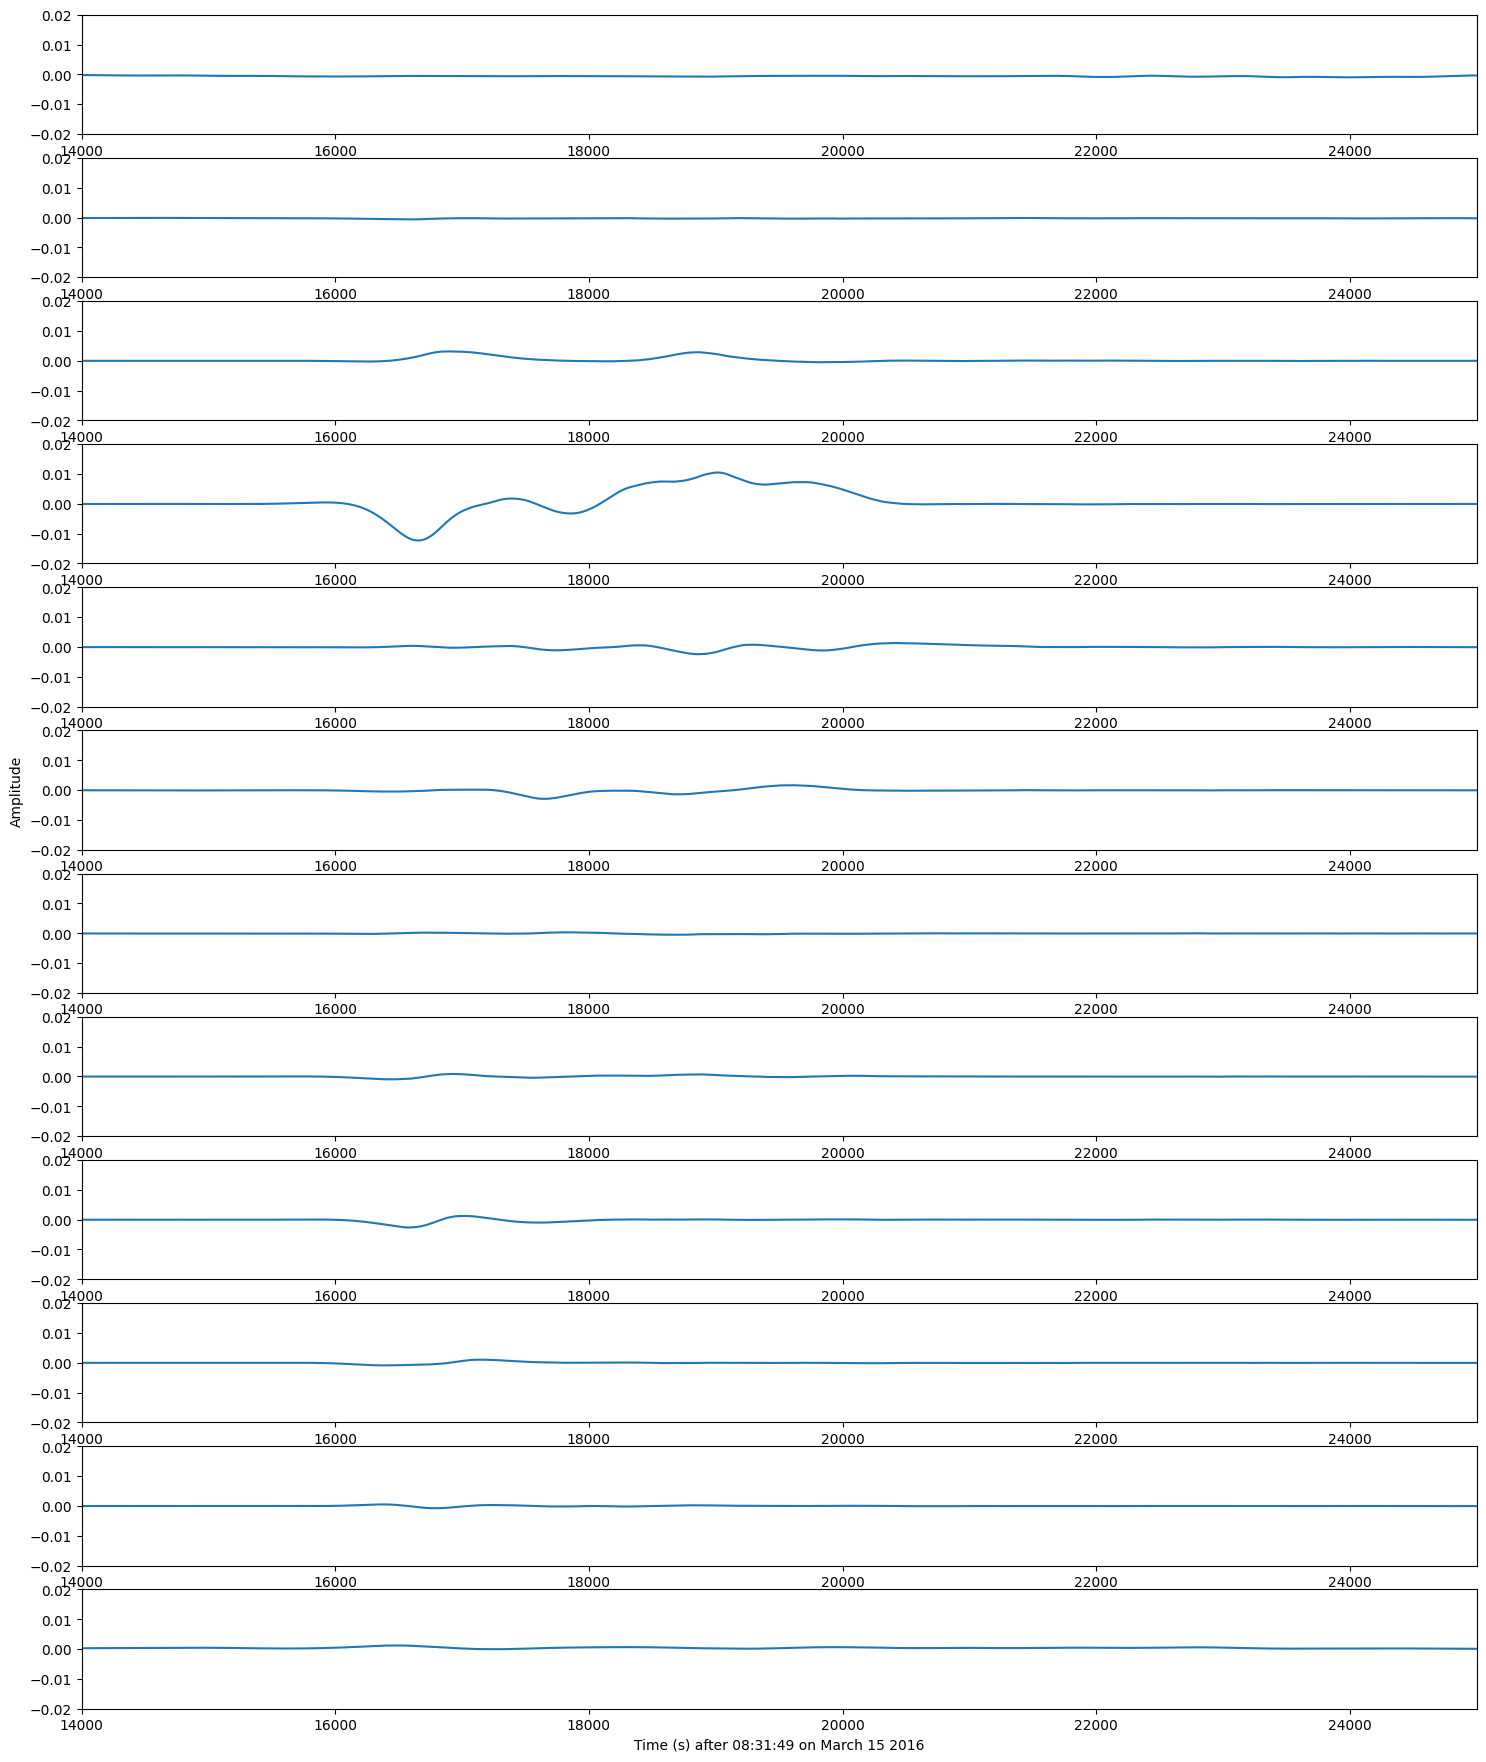

In [16]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12

for index in np.arange(num_traces):
    traces.append(event_stream_filt.traces[start_trace+trace_inc*index].data)
    
ylim = [-.02,.02]; xlim=[14000,25000]

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [18]:
filt_data = np.stack(list(t.data for t in event_stream_filt.traces)).astype('float')
size = sys.getsizeof(filt_data)
print("{:.4f} GB".format(size * 10**-9))

2.0930 GB


In [19]:
vm_filt = np.percentile(filt_data, 99)
std_filt = np.std(filt_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm_filt, filt_data.max(),std_filt))


The 99th percentile is 0.0001; the max amplitude is 0.0910; the standard deviation is  0.0012


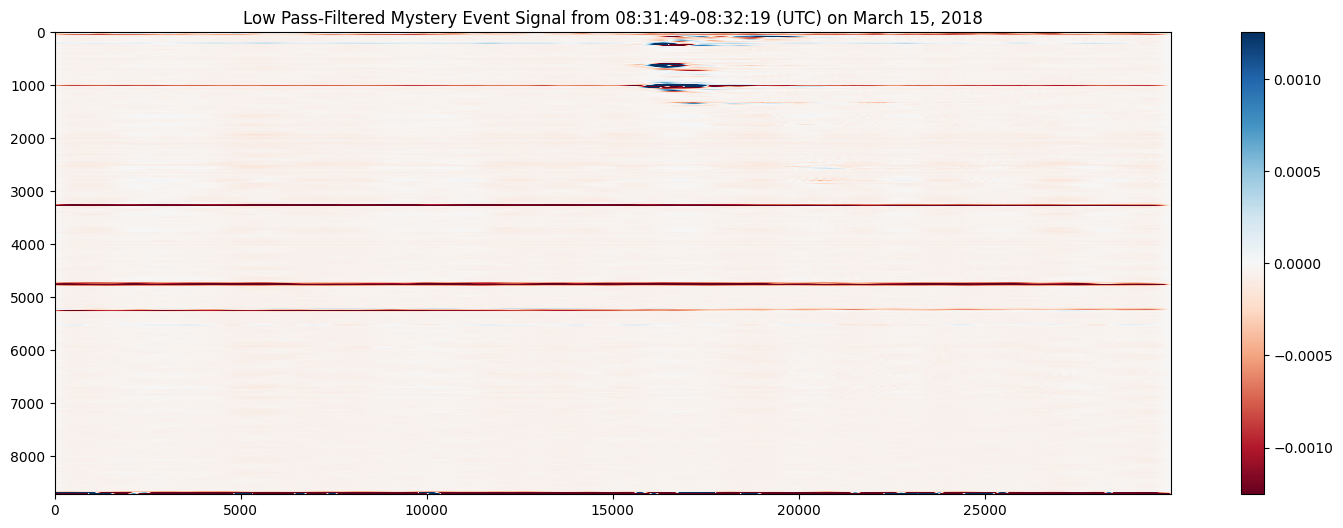

In [20]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


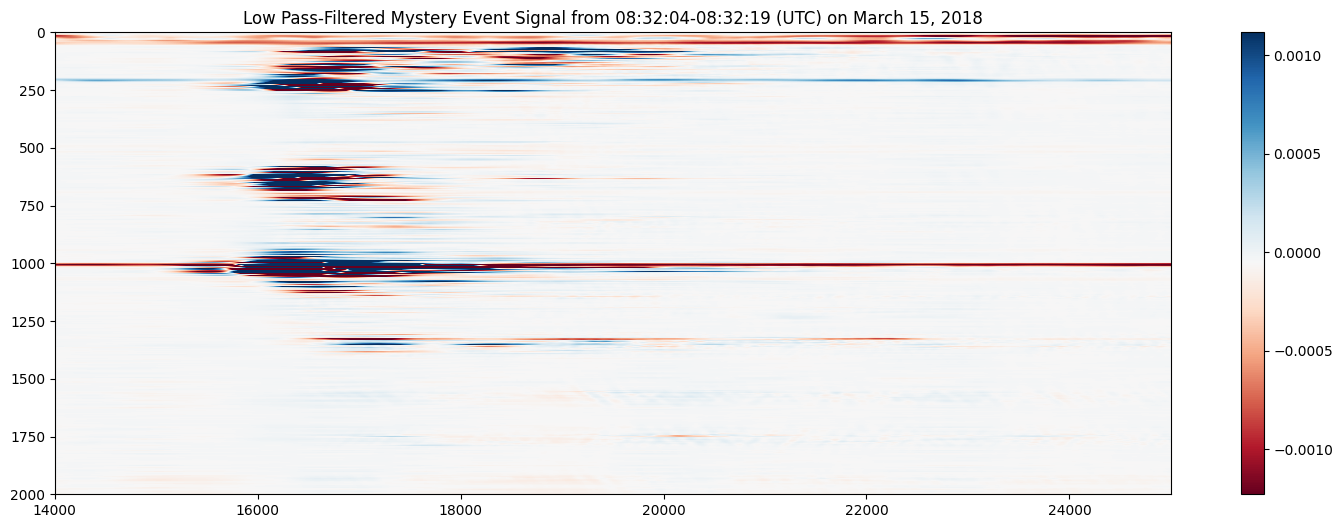

In [21]:
plt.figure(figsize=(18,6))
myster_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt+std_filt, vmax=vm_filt-std_filt, aspect='auto')
plt.xlim(14000,25000)
plt.ylim(2000,0)

plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Resampling the Data
ObsPy offers the ability to downsample data by an integer factor, or to resample data using Fourier method. For this example, we will resample the data.

In [22]:
sampling_rate = sampling_rate_stream/100 # in Hz or samples per s
event_stream_resamp = event_stream_filt.copy()
event_stream_resamp=event_stream_resamp.resample(sampling_rate,no_filter=True)


/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/2759230452.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/2759230452.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/2759230452.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/2759230452.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

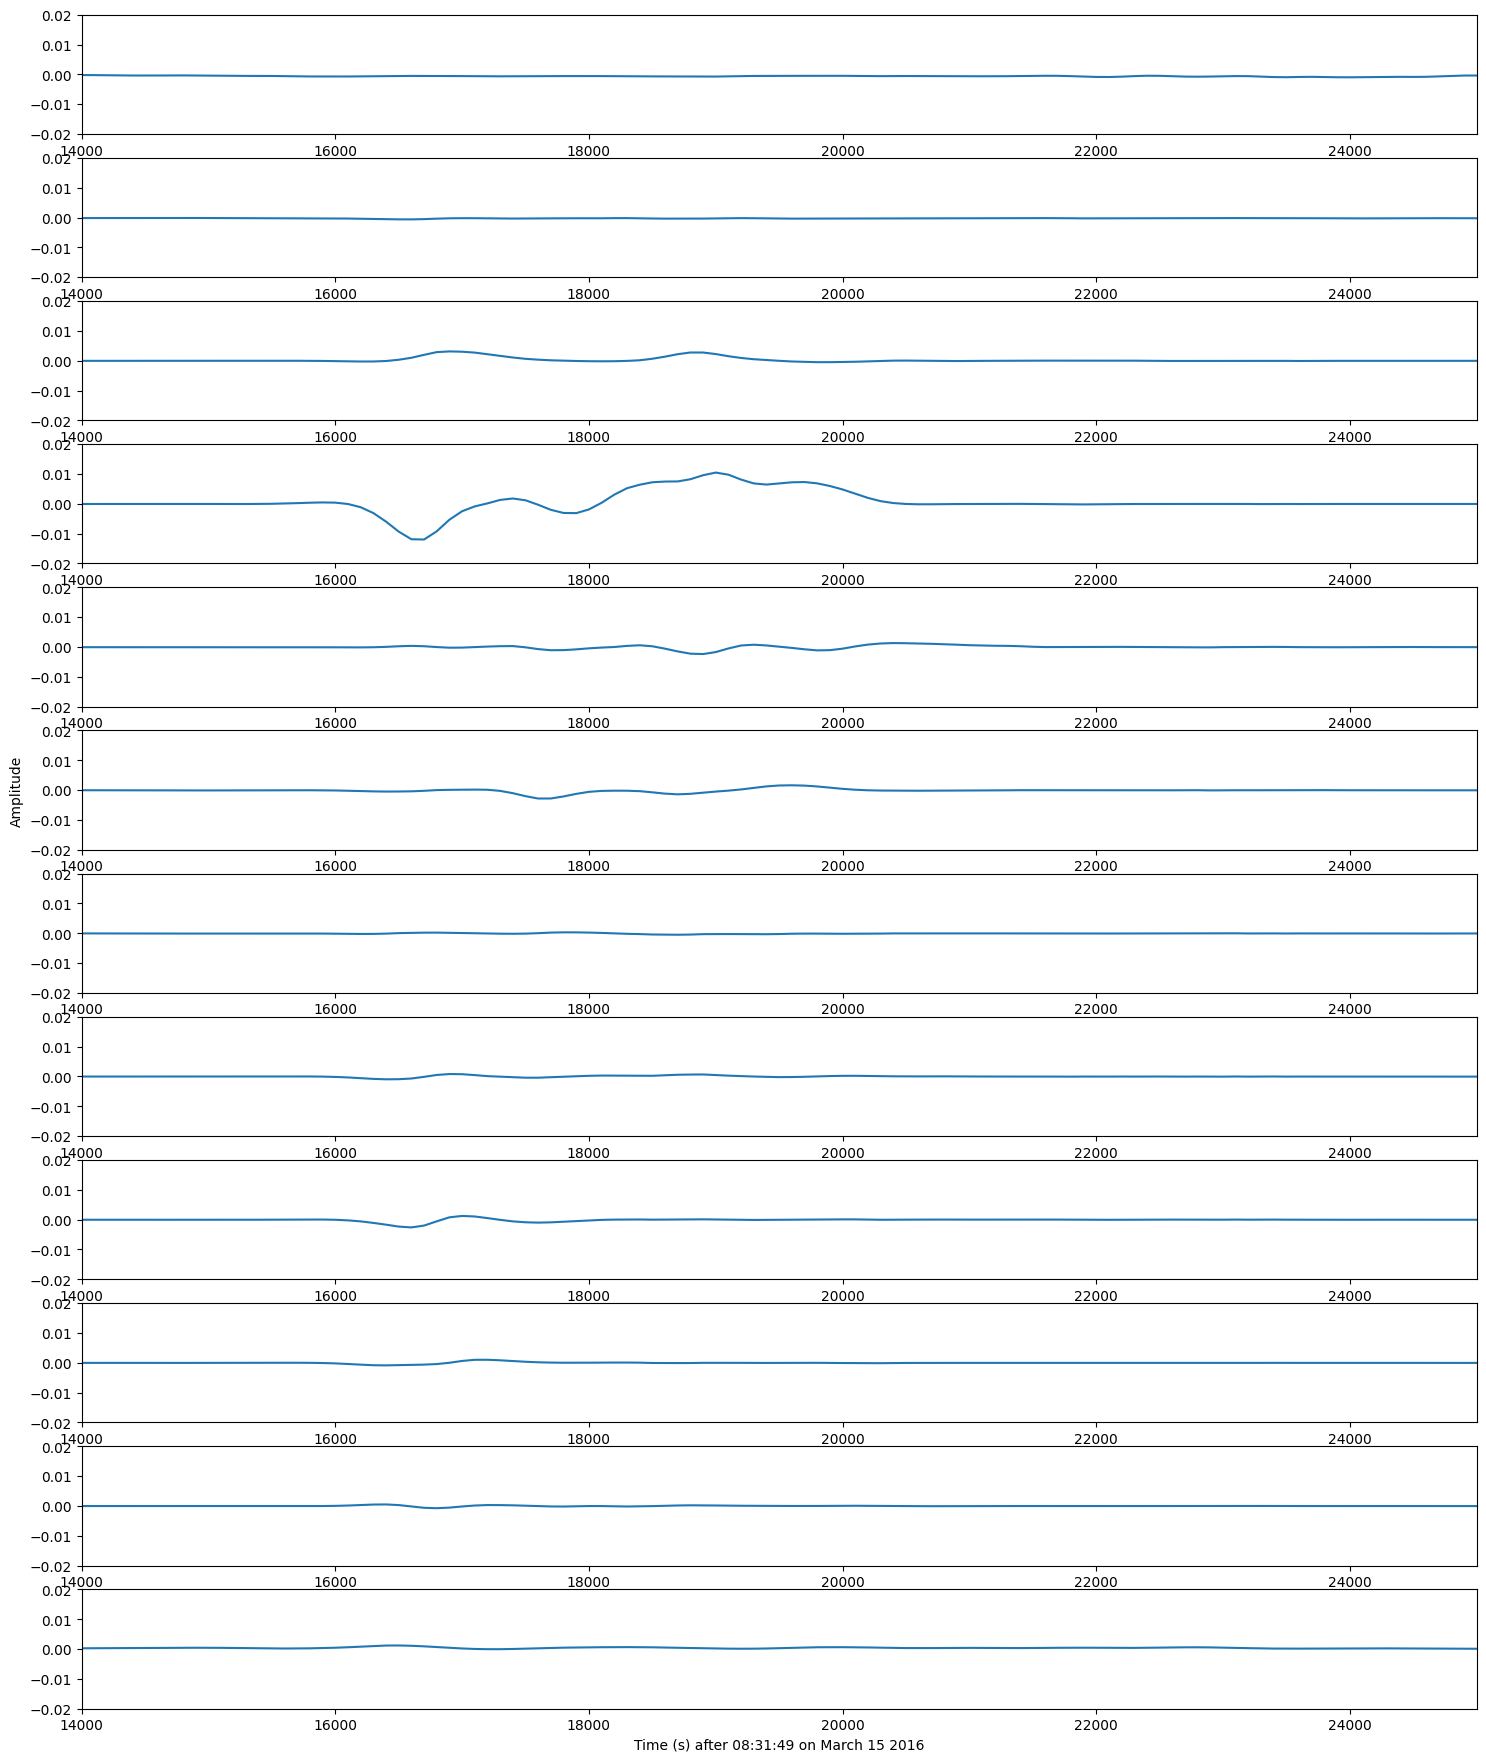

In [24]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12

for index in np.arange(num_traces):
    traces.append(event_stream_resamp.traces[start_trace+trace_inc*index].data)

ylim = [-.02,.02]; xlim=[14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate)]

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax1.set_xticklabels(np.arange(14000,25000,2000))
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax2.set_xticklabels(np.arange(14000,25000,2000))
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax3.set_xticklabels(np.arange(14000,25000,2000))
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax4.set_xticklabels(np.arange(14000,25000,2000))
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax5.set_xticklabels(np.arange(14000,25000,2000))
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_xticklabels(np.arange(14000,25000,2000))
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax7.set_xticklabels(np.arange(14000,25000,2000))
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax8.set_xticklabels(np.arange(14000,25000,2000))
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax9.set_xticklabels(np.arange(14000,25000,2000))
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax10.set_xticklabels(np.arange(14000,25000,2000))
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax11.set_xticklabels(np.arange(14000,25000,2000))
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xticklabels(np.arange(14000,25000,2000))
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [26]:
resamp_data = np.stack(list(t.data for t in event_stream_resamp.traces)).astype('float')
size = sys.getsizeof(resamp_data)
print("{:.4f} GB".format(size * 10**-9))

0.0209 GB


In [27]:
vm_resamp = np.percentile(resamp_data, 99)
std_resamp = np.std(resamp_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is {:.4f}".format(vm_resamp, resamp_data.max(),std_resamp))


The 99th percentile is 0.0001; the max amplitude is 0.0909; the standard deviation is 0.0012


/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/1968751885.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(-5000,30000,5000))


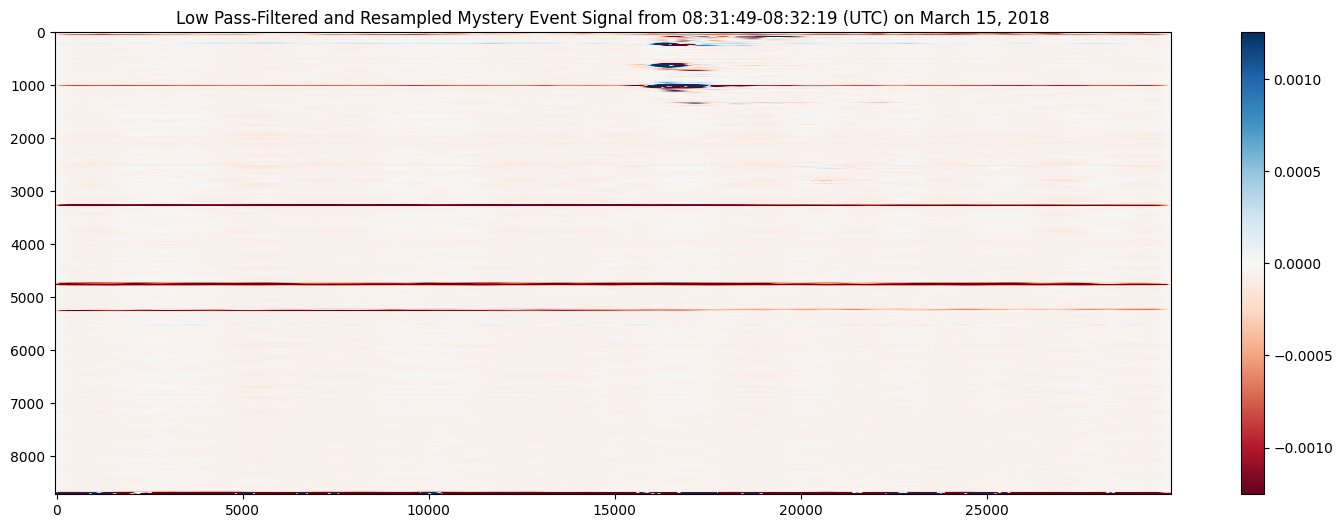

In [28]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
ax.set_xticklabels(np.arange(-5000,30000,5000))
plt.colorbar()
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/3774834154.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(14000,30000,2000))


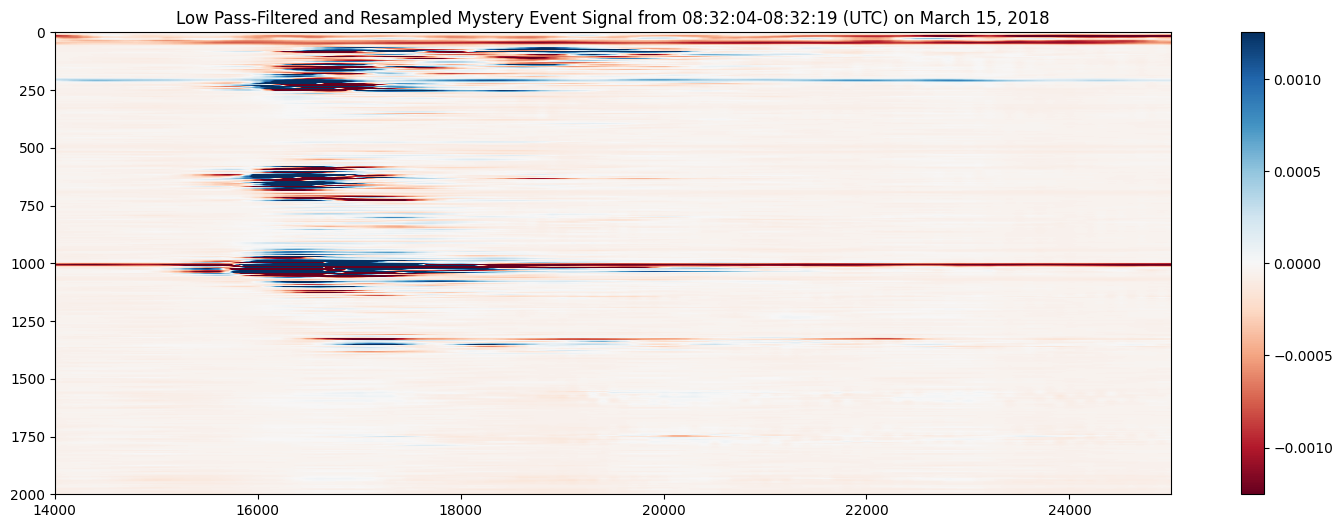

In [29]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
plt.xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
plt.ylim(2000,0)
ax.set_xticklabels(np.arange(14000,30000,2000))
plt.colorbar(mystery_event)
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Comparison of the three Mystery Event Images

/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_26794/914149496.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(np.arange(14000,30000,2000))


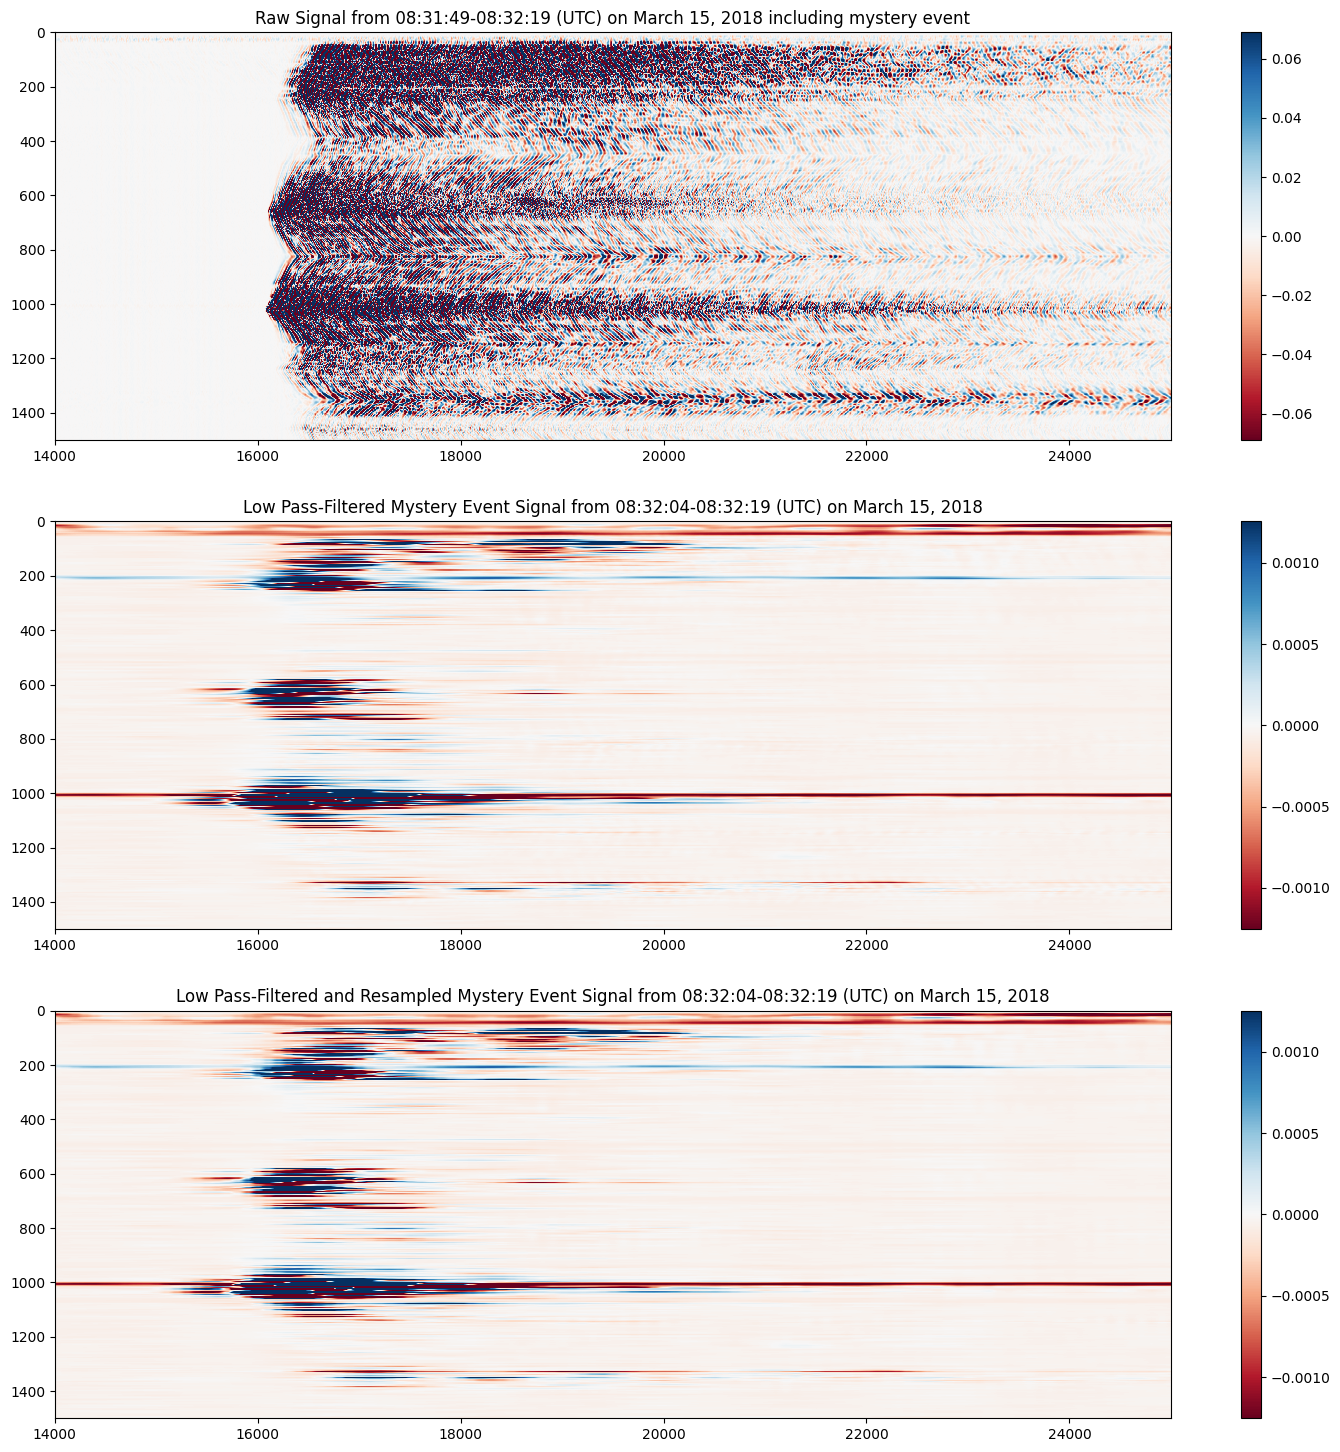

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')
ax1.set_xlim(14000,25000)
ax1.set_ylim(1500,0)

filt = ax2.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(filt,ax=ax2)
ax2.set_title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax2.set_xlim(14000,25000)
ax2.set_ylim(1500,0)

resamp = ax3.imshow(resamp_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(resamp,ax=ax3)
ax3.set_title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax3.set_xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
ax3.set_ylim(1500,0)
ax3.set_xticklabels(np.arange(14000,30000,2000))
plt.show()